In [3]:
# Import Libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
from datetime import datetime, timedelta
from scipy.stats import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from collections import Counter
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


In [4]:
with open("../data/interim/02_customer_data_preprocessed.pkl", "rb") as file:
    df4 = pickle.load(file)

In [5]:
# Dimensionality Reduction (PCA)

# Standardize or normalize the data to have zero mean and unit variance across features. 
# Extract the "CustomerID" column
customer_ids = df4['CustomerID']

# Select the columns to be scaled (excluding "CustomerID")
columns_to_scale = df4.columns.difference(['CustomerID'])

scaler = StandardScaler()  # Use StandardScaler

scaled_data = scaler.fit_transform(df4[columns_to_scale])

scaled_customer_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Re-add the "CustomerID" column
scaled_customer_df['CustomerID'] = customer_ids

scaled_customer_df = scaled_customer_df[['CustomerID'] + [col for col in scaled_customer_df.columns if col != 'CustomerID']]

# Display the scaled DataFrame
scaled_customer_df.head()


,CustomerID,Average_Monthly_Spending,Average_Value/Purchase,Cancellation_Frequency,Days_Since_Last_Purchase,Is_Outlier,Total_Products_Bought,Total_Purchases,Total_Spent,Trend
0,12346.0,-1.263727,-1.360988,0.378000,2.286295,0.0,-0.681018,-0.482066,-0.691547,0.092180
1,12347.0,0.890904,1.566897,-0.551849,-0.903795,0.0,1.624294,0.655071,1.777224,0.117840
2,12348.0,-0.006357,0.347638,-0.551849,-0.182815,0.0,1.506121,-0.027211,0.131705,-0.484873
3,12349.0,3.836825,5.570098,-0.551849,-0.745772,0.0,-0.090153,-0.709493,0.143338,0.092180
4,12350.0,-0.233503,0.038972,-0.551849,2.138149,0.0,-0.497193,-0.709493,-0.522915,0.092180


In [6]:
# Extract the "CustomerID" column
customer_ids = scaled_customer_df['CustomerID']

# Select the numeric columns (excluding "CustomerID")
numeric_columns = scaled_customer_df.columns.difference(['CustomerID'])

# Calculate the covariance matrix
cov_matrix = np.cov(scaled_customer_df[numeric_columns], rowvar=False)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort eigenvalues in descending order
sorted_indices = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Cross-validation to select the number of components
num_components_to_try = range(1, len(numeric_columns) + 1)
cumulative_variance_explained = []
for num_components in num_components_to_try:
    pca = PCA(n_components=num_components)
    pca.fit(scaled_customer_df[numeric_columns])
    variance_explained = sum(pca.explained_variance_ratio_)
    cumulative_variance_explained.append(variance_explained)

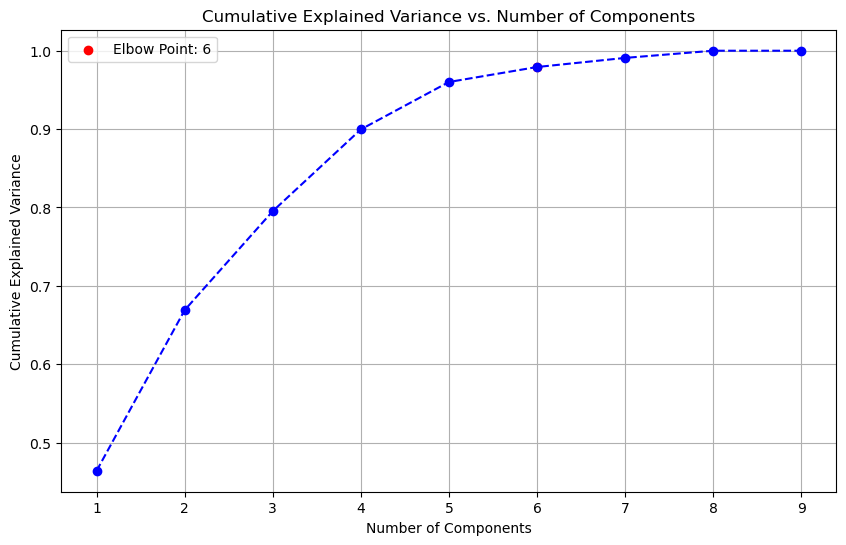

Elbow Point at 6 components


In [7]:
num_components = range(1, len(cumulative_variance_explained) + 1)

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(10, 6))
plt.plot(num_components, cumulative_variance_explained, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)

# Find the elbow point
elbow_point = None
for i in range(1, len(cumulative_variance_explained)):
    if cumulative_variance_explained[i] - cumulative_variance_explained[i - 1] < 0.02: 
        elbow_point = i
        break

# Plot the elbow point
if elbow_point is not None:
    plt.scatter(elbow_point + 1, cumulative_variance_explained[elbow_point], color='red', label=f'Elbow Point: {elbow_point + 1}')

plt.legend()
plt.show()

# The elbow point is where you might choose the number of components
if elbow_point is not None:
    print(f'Elbow Point at {elbow_point + 1} components')

In [8]:
# PCA

pca = PCA(n_components=6)
reduced_data = pca.fit_transform(scaled_customer_df[numeric_columns])

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
reduced_data = pd.DataFrame(reduced_data, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Merge the "CustomerID" column back to the new PCA dataframe
reduced_data = pd.merge(scaled_customer_df[['CustomerID']], reduced_data, left_index=True, right_index=True)

# Reset the index in scaled_customer_df
scaled_customer_df.reset_index(inplace=True)

# Merge the "CustomerID" column back to the new PCA dataframe
reduced_data = pd.merge(scaled_customer_df[['CustomerID']], reduced_data, on='CustomerID')

# Display the resulting DataFrame
reduced_data.head()

,CustomerID,PC1,PC2,PC3,PC4,PC5,PC6
0,12346.0,-2.137939,-0.994505,0.182445,2.084951,0.090332,0.200406
1,12347.0,2.732179,1.149014,-0.395158,-0.603836,0.991247,0.097086
2,12348.0,0.737009,0.426508,0.313504,-0.232665,1.063404,0.780635
3,12349.0,2.781008,5.658191,-0.226085,-0.970128,-2.229524,-0.666519
4,12350.0,-1.514532,0.834310,0.020027,1.706037,0.218188,-0.056013


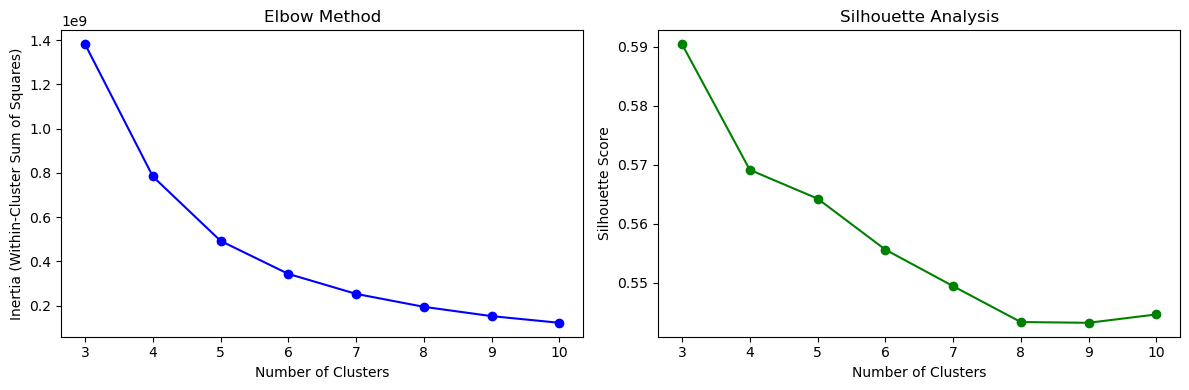

In [10]:
# Create a range of possible cluster numbers to try
cluster_range = range(3, 11)

# Initialize lists to store the inertia and silhouette scores
inertia_values = []
silhouette_scores = []

# Fit K-means clustering for each cluster number and collect scores
for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
    kmeans.fit(reduced_data)

    inertia_values.append(kmeans.inertia_)

    # Silhouette score for silhouette analysis
    if num_clusters > 1:
        silhouette_scores.append(silhouette_score(reduced_data, kmeans.labels_))
    else:
        silhouette_scores.append(None)  # Silhouette score undefined for a single cluster

# Plot the Elbow Method
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')

# Plot Silhouette Analysis
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

In [11]:
matrix = reduced_data.values 

for n_clusters in range(3, 11):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is:", silhouette_avg)

For n_clusters = 3 The average silhouette_score is: 0.5903733717805365
For n_clusters = 4 The average silhouette_score is: 0.5691843808462317
For n_clusters = 5 The average silhouette_score is: 0.5643013975304241
For n_clusters = 6 The average silhouette_score is: 0.555599673451568
For n_clusters = 7 The average silhouette_score is: 0.5499785976756748
For n_clusters = 8 The average silhouette_score is: 0.5437067044517965
For n_clusters = 9 The average silhouette_score is: 0.54318333139811
For n_clusters = 10 The average silhouette_score is: 0.5442333040783317


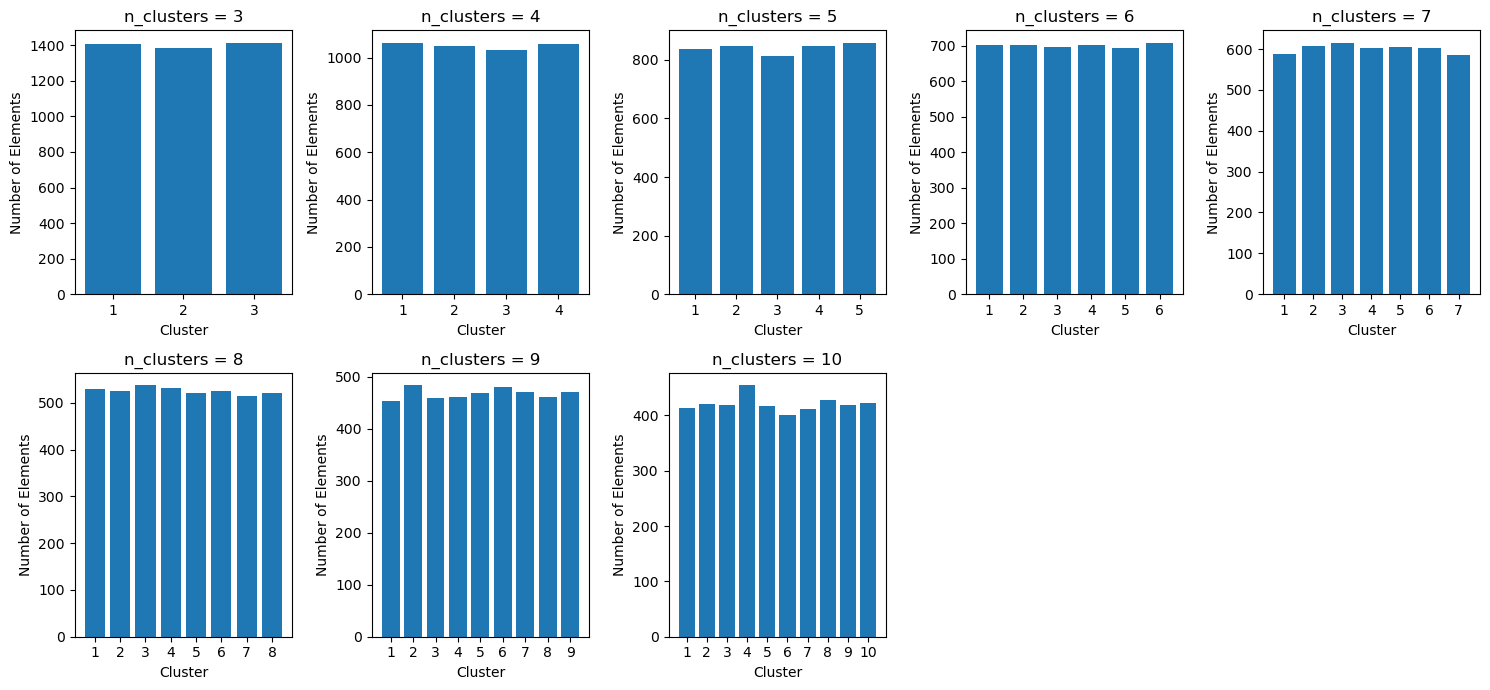

In [12]:
# Lists to store the results
n_clusters_list = []
num_elements_list = []

# Create a 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

for n_clusters in range(3, 11):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)

    n_clusters_list.append(n_clusters)
    num_elements_in_clusters = []
    for cluster_id in range(n_clusters):
        num_elements = sum(clusters == cluster_id)
        num_elements_in_clusters.append(num_elements)

    num_elements_list.append(num_elements_in_clusters)

# Create bar charts in a 2x5 grid
for i in range(len(n_clusters_list)):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.bar([str(cluster_id) for cluster_id in range(1, n_clusters_list[i] + 1)], num_elements_list[i])
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Number of Elements')
    ax.set_title(f'n_clusters = {n_clusters_list[i]}')
    
# Remove the last 2 subplots
for i in range(2):
    row = 1
    col = 3 + i
    fig.delaxes(axes[row, col])


# Adjust layout and show the subplots
plt.tight_layout()
plt.show()

In [13]:
# Apply KMeans clustering using the optimal k (K = 3 looks to be best)
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(reduced_data)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Create a copy of the reduced_data DataFrame to avoid the SettingWithCopyWarning
df5 = reduced_data.copy()

# Add the 'Cluster' column to the DataFrame
df5['Cluster'] = new_labels

# Display the first few rows of the DataFrame to verify the changes
df5.head()


,CustomerID,PC1,PC2,PC3,PC4,PC5,PC6,Cluster
0,12346.0,-2.137939,-0.994505,0.182445,2.084951,0.090332,0.200406,0
1,12347.0,2.732179,1.149014,-0.395158,-0.603836,0.991247,0.097086,0
2,12348.0,0.737009,0.426508,0.313504,-0.232665,1.063404,0.780635,0
3,12349.0,2.781008,5.658191,-0.226085,-0.970128,-2.229524,-0.666519,0
4,12350.0,-1.514532,0.834310,0.020027,1.706037,0.218188,-0.056013,0


In [14]:
df5.to_pickle("../data/interim/03_customer_data_preprocessed.pkl")